In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
import matplotlib.dates as mdates
from bs4 import BeautifulSoup
import requests
import glob
import numpy as np
import yfinance as yf
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [3]:
# # 파일 경로 패턴 설정 (여기서는 forecast_*.csv 파일만 가져옴)
# file_list = glob.glob('../data/raw/forecast_*.csv')

# # 모든 파일을 읽어서 하나의 데이터프레임으로 합치기
# df_list = [pd.read_csv(file, encoding='euc-kr') for file in file_list]
# forecast_df = pd.concat(df_list, ignore_index=True)

# # CSV 파일로 저장
# forecast_df.to_csv('../data/processed/forecast_merged2.csv', index=False)


In [4]:
# 파일 경로 설정
file_path = '../data/processed/forecast_merged2.csv'
forecast_df = pd.read_csv(file_path)


#일시 데이트타임 적용
forecast_df['일시'] = pd.to_datetime(forecast_df['일시'])
forecast_df['연도'] = forecast_df['일시'].dt.year
forecast_df['월'] = forecast_df['일시'].dt.month
forecast_df['일'] = forecast_df['일시'].dt.day
forecast_df['시간'] = forecast_df['일시'].dt.hour
forecast_df['요일'] = forecast_df['일시'].dt.day_name().str[:3]

# 결측치 제거
forecast_df.fillna(0, inplace=True)

#데이터 타입 숫자인지 확인????
numeric_columns = forecast_df.select_dtypes(include=['float64', 'int64']).columns
forecast_df[numeric_columns] = forecast_df[numeric_columns].apply(pd.to_numeric, errors='coerce')


# 결과 확인
forecast_df.head(-5)

,지점,일시,풍속(m/s),풍향(deg),GUST풍속(m/s),현지기압(hPa),습도(%),기온(°C),수온(°C),최대파고(m),유의파고(m),평균파고(m),파주기(sec),파향(deg),연도,월,일,시간,요일
0,22105,2020-01-01 00:00:00,6.4,284.0,9.3,1027.5,48.0,3.2,14.8,3.5,2.0,1.4,8.0,41.0,2020,1,1,0,Wed
1,22105,2020-01-01 01:00:00,6.6,309.0,9.6,1026.7,44.0,3.0,14.8,3.7,1.9,1.4,8.0,45.0,2020,1,1,1,Wed
2,22105,2020-01-01 02:00:00,7.3,292.0,10.7,1026.6,50.0,3.4,14.8,3.4,2.2,1.6,8.0,43.0,2020,1,1,2,Wed
3,22105,2020-01-01 03:00:00,7.7,294.0,11.1,1026.6,47.0,2.8,14.8,3.2,1.9,1.3,5.8,22.0,2020,1,1,3,Wed
4,22105,2020-01-01 04:00:00,7.4,292.0,10.5,1025.9,54.0,3.1,14.8,3.1,2.0,1.4,8.0,45.0,2020,1,1,4,Wed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336095,22302,2025-01-12 14:00:00,12.8,308.0,15.6,1016.1,71.0,5.0,13.5,4.3,2.3,1.5,7.7,357.0,2025,1,12,14,Sun
336096,22302,2025-01-12 15:00:00,12.7,306.0,16.8,1016.2,70.0,5.3,13.5,3.6,2.2,1.5,6.5,335.0,2025,1,12,15,Sun
336097,22302,2025-01-12 16:00:00,13.9,310.0,16.5,1016.4,71.0,5.4,13.5,3.9,2.4,1.6,7.4,343.0,2025,1,12,16,Sun
336098,22302,2025-01-12 17:00:00,13.3,300.0,16.5,1016.6,70.0,5.6,13.4,4.5,2.6,1.6,8.0,341.0,2025,1,12,17,Sun


In [5]:
# 실시간 추가(셀레니움?) -- 강사님께 제지당함

# url = 'https://data.kma.go.kr/data/sea/selectBuoyRltmList.do?pgmNo=52'

# # 2️⃣ HTTP 요청을 보내서 웹 페이지 가져오기
# response = requests.get(url)

# # 3️⃣ BeautifulSoup을 사용해 HTML 파싱
# soup = BeautifulSoup(response.text, 'html.parser')

# # 4️⃣ 원하는 데이터 추출 (예: 모든 제목 태그 <h1>)
# titles = soup.find_all('h1')

# # 5️⃣ 추출한 데이터를 출력
# for title in titles:
#     print(title.get_text())

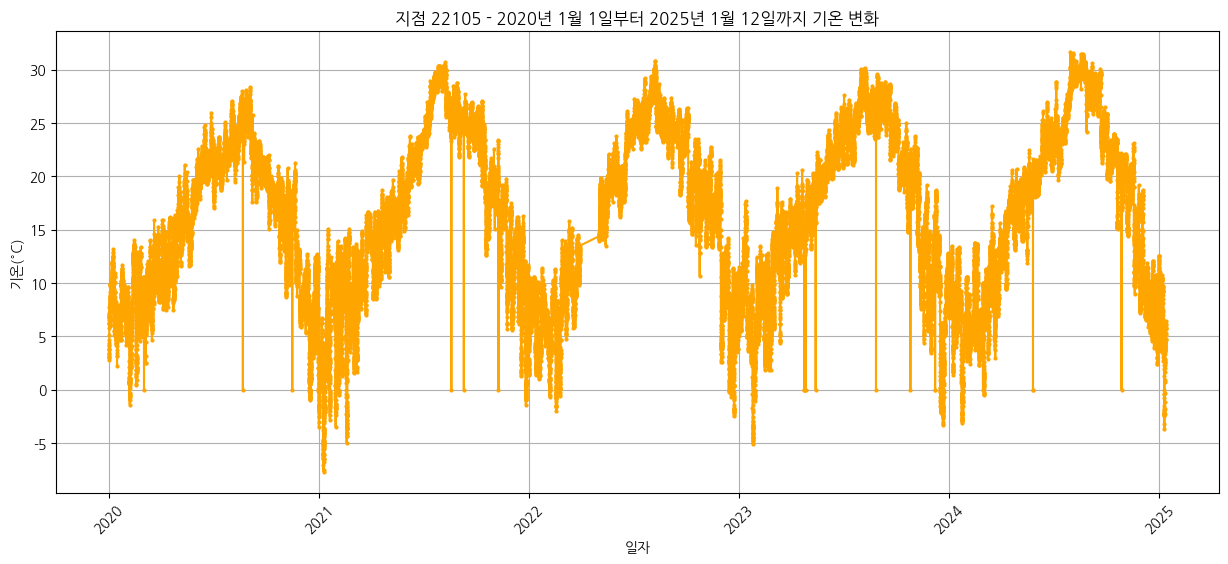

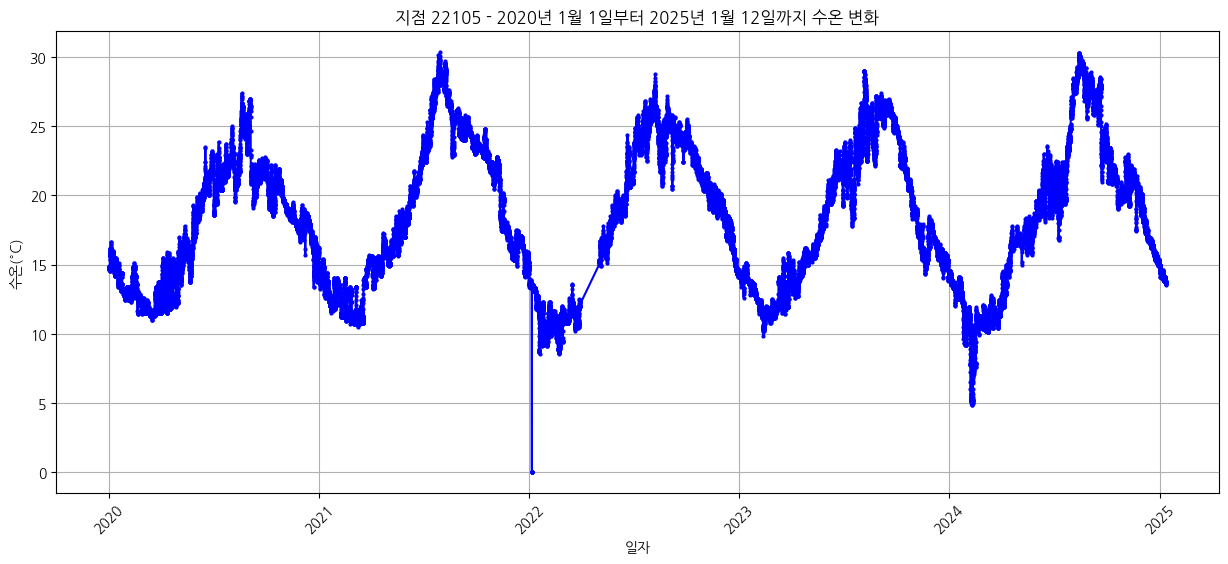

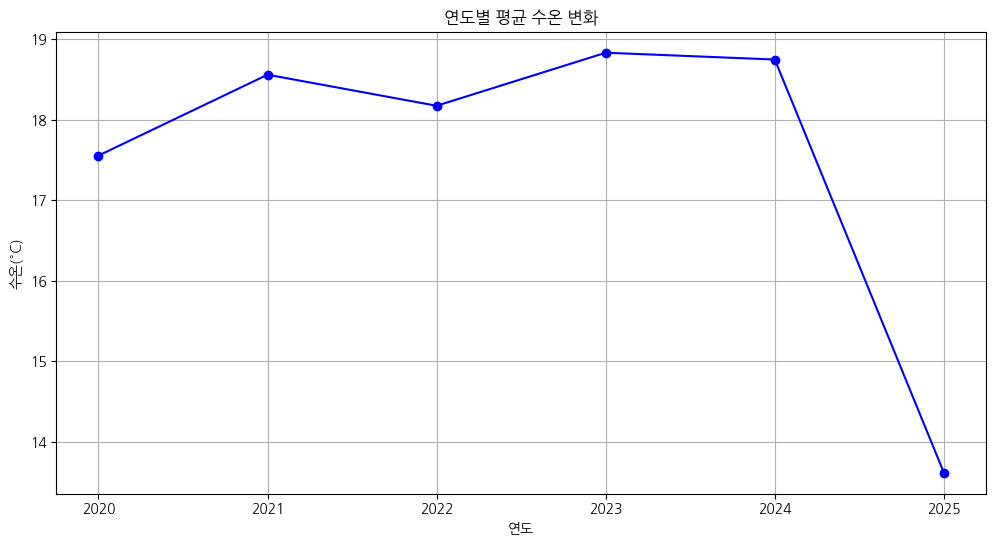

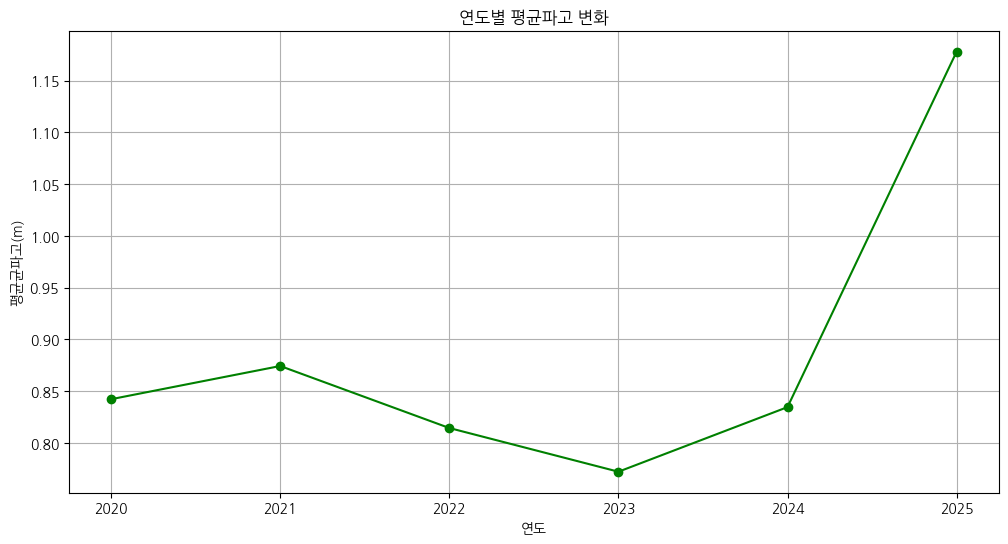

In [6]:
# 1️⃣ 지점 22105 데이터 필터링 (2020년 1월 1일부터 2025년 1월 12일까지)
filtered_df = forecast_df[(forecast_df['지점'] == 22105) & (forecast_df['일시'] >= '2020-01-01') & (forecast_df['일시'] <= '2025-01-12')]

# 2️⃣ '일시'를 인덱스로 설정
filtered_df.set_index('일시', inplace=True)

# 3️⃣ 기온 변화 시각화
plt.figure(figsize=(15, 6))
plt.plot(filtered_df.index, filtered_df['기온(°C)'], color='orange', linestyle='-', marker='o', markersize=2)
plt.title('지점 22105 - 2020년 1월 1일부터 2025년 1월 12일까지 기온 변화')
plt.xlabel('일자')
plt.ylabel('기온(°C)')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# 4️⃣ 수온 변화 시각화
plt.figure(figsize=(15, 6))
plt.plot(filtered_df.index, filtered_df['수온(°C)'], color='blue', linestyle='-', marker='o', markersize=2)
plt.title('지점 22105 - 2020년 1월 1일부터 2025년 1월 12일까지 수온 변화')
plt.xlabel('일자')
plt.ylabel('수온(°C)')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


plt.figure(figsize=(12, 6))
yearly_temp = forecast_df.groupby('연도')['수온(°C)'].mean()
plt.plot(yearly_temp.index, yearly_temp.values, marker='o', color='blue')
plt.title('연도별 평균 수온 변화')
plt.xlabel('연도')
plt.ylabel('수온(°C)')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
hourly_wave = forecast_df.groupby('연도')['평균파고(m)'].mean()
plt.plot(hourly_wave.index, hourly_wave.values, marker='o', color='green')
plt.title('연도별 평균파고 변화')
plt.xlabel('연도')
plt.ylabel('평균균파고(m)')
plt.grid(True)
plt.show()

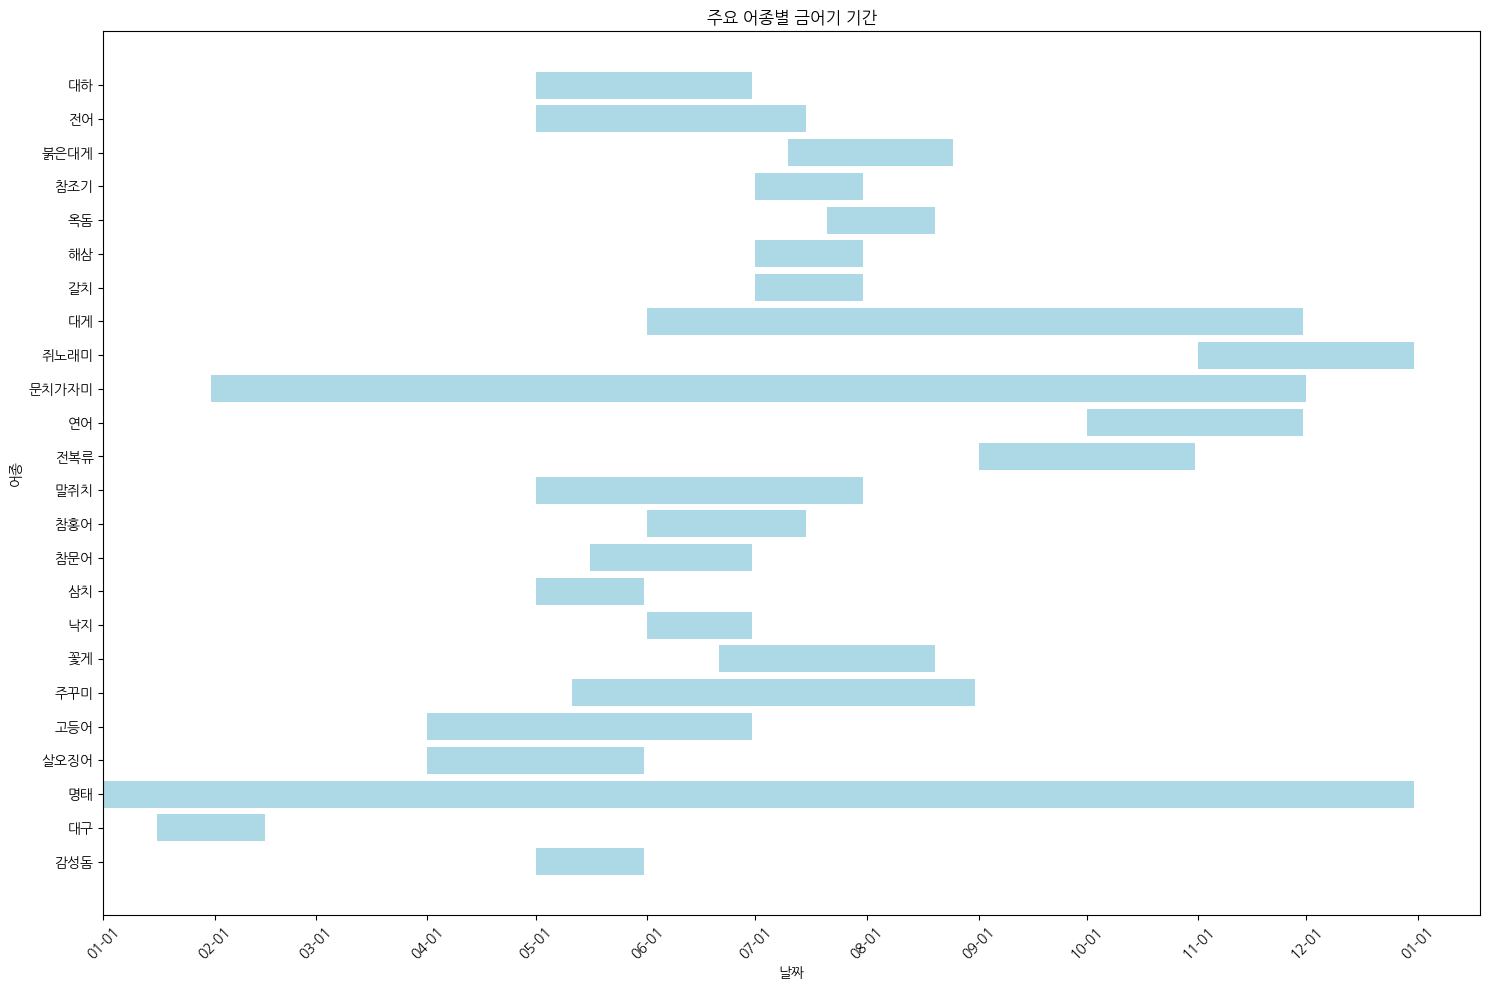

In [9]:
file_path = "../data/raw/금어기_데이터.csv"
df = pd.read_csv(file_path, encoding='utf-8-sig')

# 날짜 형식 변환
df['포획금지 시작일'] = pd.to_datetime(df['포획금지 시작일'], format='%m월 %d일')
df['포획금지 종료일'] = pd.to_datetime(df['포획금지 종료일'], format='%m월 %d일')

# 금어기 기간 계산
df['금어기 기간'] = df['포획금지 종료일'] - df['포획금지 시작일']

# 시각화
fig, ax = plt.subplots(figsize=(15, 10))

# Gantt 차트 생성
for i, row in df.iterrows():
    ax.barh(row['어종'], row['금어기 기간'].days, left=row['포획금지 시작일'], color='lightblue')

# 날짜 포맷 설정
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)

# 그래프 제목 및 레이블 설정
plt.title('주요 어종별 금어기 기간')
plt.xlabel('날짜')
plt.ylabel('어종')
plt.tight_layout()
plt.show()

In [ ]:
# 데이터 경로 설정
forecast_file_path = "../data/processed/forecast_merged2.csv"
price_file_path = "../data/raw/ikh_item_price_2025-01-15.csv"

# 데이터 불러오기
forecast_df = pd.read_csv(forecast_file_path)
price_df = pd.read_csv(price_file_path)

# 1. 날짜 형식 변환
forecast_df['일시'] = pd.to_datetime(forecast_df['일시'], errors='coerce')
price_df['priceDate'] = pd.to_datetime(price_df['priceDate'], errors='coerce')

# 2. 날짜 기준으로 두 데이터 병합
merged_df = pd.merge(price_df, forecast_df, left_on='priceDate', right_on='일시', how='inner')

# 3. 금어기 데이터 추가 - 가상 금어기 정보
# goldfish_season = {
#     '농어': ('2022-05-01', '2022-06-30'),
#     '광어': ('2022-04-01', '2022-05-31'),
#     '대게': ('2022-07-01', '2022-08-31'),
#     '연어': ('2022-09-01', '2022-10-31'),
#     '우럭': ('2022-06-01', '2022-07-31'),
#     '참돔': ('2022-03-01', '2022-04-30'),
#     '방어': ('2022-11-01', '2022-12-31')
# }

# 금어기 컬럼 추가
for item, (start, end) in goldfish_season.items():
    merged_df.loc[(merged_df['item'] == item) & (merged_df['priceDate'] >= pd.to_datetime(start)) &
                  (merged_df['priceDate'] <= pd.to_datetime(end)), '금어기'] = True
merged_df['금어기'].fillna(False, inplace=True)

# 4. 결측치 처리
numeric_columns = merged_df.select_dtypes(include=['float64', 'int64']).columns
merged_df[numeric_columns] = merged_df[numeric_columns].apply(pd.to_numeric, errors='coerce')
merged_df.fillna(0, inplace=True)

# ✅ 데이터프레임 출력 함수 (로컬 환경용)
def display_dataframe_to_user(name, dataframe):
    print(f"📊 {name}")
    display(dataframe)

# 데이터프레임 확인
display_dataframe_to_user(name="Merged Fish Price and Weather Data", dataframe=merged_df)



C:\Users\user\AppData\Local\Temp\ipykernel_13260\4088320752.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['금어기'].fillna(False, inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_13260\4088320752.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df['금어기'].fillna(False, inplace=Tr

📊 Merged Fish Price and Weather Data


,priceDate,minPrice,avgPrice,maxPrice,item,market,지점,일시,풍속(m/s),풍향(deg),...,현지기압(hPa),습도(%),기온(°C),수온(°C),최대파고(m),유의파고(m),평균파고(m),파주기(sec),파향(deg),금어기
0,2020-01-01,25000,28130,30000,농어,노량진 1층,22105,2020-01-01,6.4,284.0,...,1027.5,48.0,3.2,14.8,3.5,2.0,1.4,8.0,41.0,False
1,2020-01-01,25000,28130,30000,농어,노량진 1층,22107,2020-01-01,11.0,354.0,...,1032.2,70.0,5.1,17.6,3.2,2.0,1.4,8.0,357.0,False
2,2020-01-01,25000,28130,30000,농어,노량진 1층,22186,2020-01-01,6.0,326.0,...,1034.2,56.0,1.7,11.1,2.8,1.6,1.2,6.4,333.0,False
3,2020-01-01,25000,28130,30000,농어,노량진 1층,22188,2020-01-01,5.2,348.0,...,1030.7,42.0,2.3,11.6,1.5,0.8,0.6,3.4,298.0,False
4,2020-01-01,25000,28130,30000,농어,노량진 1층,22189,2020-01-01,7.6,317.0,...,0.0,47.0,3.8,17.5,4.4,3.0,2.1,10.7,36.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713206,2020-12-25,30000,30000,30000,방어,부산민락어민활어직판장,22186,2020-12-25,10.7,323.0,...,1024.5,53.0,6.3,11.2,3.0,2.2,1.5,6.4,316.0,False
713207,2020-12-25,30000,30000,30000,방어,부산민락어민활어직판장,22188,2020-12-25,12.1,322.0,...,1018.8,52.0,6.3,13.0,2.1,1.5,1.0,4.6,297.0,False
713208,2020-12-25,30000,30000,30000,방어,부산민락어민활어직판장,22189,2020-12-25,8.9,338.0,...,1017.0,52.0,7.2,17.5,2.2,1.4,1.0,4.3,345.0,False
713209,2020-12-25,30000,30000,30000,방어,부산민락어민활어직판장,22190,2020-12-25,9.2,287.0,...,1016.5,47.0,7.6,14.4,3.3,1.9,1.4,6.4,359.0,False


AttributeError: 'NoneType' object has no attribute 'info'

In [ ]:
# 파일 경로 설정
redtide_path = '../data/raw/적조데이터.csv'
redtide_df = pd.read_csv(redtide_path)

# 1. 날짜 형식 변환
redtide_df['예찰일자'] = pd.to_datetime(redtide_df['예찰일자'], errors='coerce')

# 2. 발생해역 범주화
region_mapping = {
    '전남': 1, '울산': 2, '경남': 3, '부산': 4, '제주': 5
}

redtide_df['발생해역_범주'] = redtide_df['발생해역'].apply(lambda x: next((v for k, v in region_mapping.items() if k in str(x)), 0))

# 3. 적조생물 범주화
species_list = [
    'Cochlodinium polykrikoides', 'Noctiluca sp.', 'Mesodinium rubrum',
    'Ceratium furca', 'Akashiwo sanguinea', 'Heterosigma akashiwo', 'Skeletonema'
]

redtide_df['적조생물_범주'] = redtide_df['적조생물'].apply(lambda x: x if x in species_list else '기타')

# 4. 밀도, 수온, 염분 중간값 처리
def calculate_mid_value(range_str):
    try:
        start, end = map(float, range_str.split('~'))
        return (start + end) / 2
    except:
        return None

redtide_df['밀도(개체수/mL)'] = redtide_df['밀도(개체수/mL)'].apply(calculate_mid_value)
redtide_df['수온(C)'] = redtide_df['수온(C)'].apply(calculate_mid_value)
redtide_df['염분'] = redtide_df['염분'].apply(calculate_mid_value)

# 5. 날짜 기준 병합
combined_df = pd.merge(merged_df, redtide_df, left_on='priceDate', right_on='예찰일자', how='left')

# 6. 결측치 처리
combined_df.fillna(0, inplace=True)

# ✅ 데이터프레임 출력 함수
def display_dataframe_to_user(name, dataframe):
    print(f"📊 {name}")
    display(dataframe)

# 데이터프레임 확인
display_dataframe_to_user(name="Combined DataFrame", dataframe=combined_df)

# 금어기 컬럼 제거
combined_df.drop(columns=['금어기'], inplace=True)

# # 데이터프레임을 CSV 파일로 저장
# output_path = '../data/raw/combined_data.csv'
# combined_df.to_csv(output_path, index=False, encoding='utf-8-sig')

# print(f"✅ 금어기 컬럼을 제거한 데이터프레임이 {output_path} 경로에 저장되었습니다.")

C:\Users\user\AppData\Local\Temp\ipykernel_13260\1932869694.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  combined_df.fillna(0, inplace=True)


📊 Combined DataFrame


,priceDate,minPrice,avgPrice,maxPrice,item,market,지점,일시,풍속(m/s),풍향(deg),...,금어기,예찰일자,발생해역,적조생물,밀도(개체수/mL),수온(C),염분,좌표,발생해역_범주,적조생물_범주
0,2020-01-01,25000,28130,30000,농어,노량진 1층,22105,2020-01-01,6.4,284.0,...,False,0,0,0,0.0,0.0,0.0,0,0.0,0
1,2020-01-01,25000,28130,30000,농어,노량진 1층,22107,2020-01-01,11.0,354.0,...,False,0,0,0,0.0,0.0,0.0,0,0.0,0
2,2020-01-01,25000,28130,30000,농어,노량진 1층,22186,2020-01-01,6.0,326.0,...,False,0,0,0,0.0,0.0,0.0,0,0.0,0
3,2020-01-01,25000,28130,30000,농어,노량진 1층,22188,2020-01-01,5.2,348.0,...,False,0,0,0,0.0,0.0,0.0,0,0.0,0
4,2020-01-01,25000,28130,30000,농어,노량진 1층,22189,2020-01-01,7.6,317.0,...,False,0,0,0,0.0,0.0,0.0,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
806596,2020-12-25,30000,30000,30000,방어,부산민락어민활어직판장,22186,2020-12-25,10.7,323.0,...,False,0,0,0,0.0,0.0,0.0,0,0.0,0
806597,2020-12-25,30000,30000,30000,방어,부산민락어민활어직판장,22188,2020-12-25,12.1,322.0,...,False,0,0,0,0.0,0.0,0.0,0,0.0,0
806598,2020-12-25,30000,30000,30000,방어,부산민락어민활어직판장,22189,2020-12-25,8.9,338.0,...,False,0,0,0,0.0,0.0,0.0,0,0.0,0
806599,2020-12-25,30000,30000,30000,방어,부산민락어민활어직판장,22190,2020-12-25,9.2,287.0,...,False,0,0,0,0.0,0.0,0.0,0,0.0,0


✅ 금어기 컬럼을 제거한 데이터프레임이 ../data/raw/combined_data.csv 경로에 저장되었습니다.


In [ ]:
main_Data = '../data/raw/combined_data.csv'
main_df = pd.read_csv(main_Data)
# main_df.info(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 806601 entries, 0 to 806600
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   파향(deg)     806601 non-null  int64  
 1   예찰일자        806601 non-null  object 
 2   발생해역        806601 non-null  object 
 3   적조생물        806601 non-null  object 
 4   밀도(개체수/mL)  806601 non-null  float64
 5   수온(C).1     806601 non-null  float64
 6   염분          806601 non-null  float64
 7   좌표          806601 non-null  object 
 8   발생해역_범주     806601 non-null  int64  
 9   적조생물_범주     806601 non-null  object 
dtypes: float64(3), int64(2), object(5)
memory usage: 61.5+ MB
None


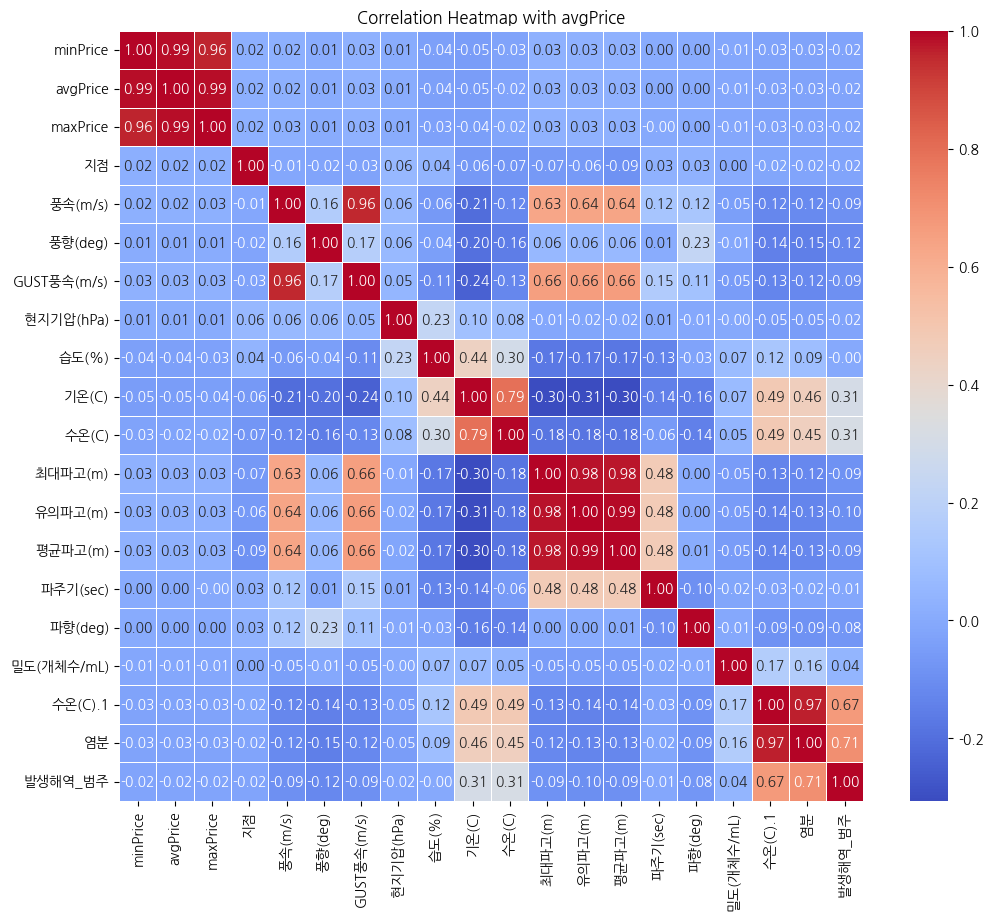

Mean Squared Error: 561415.85


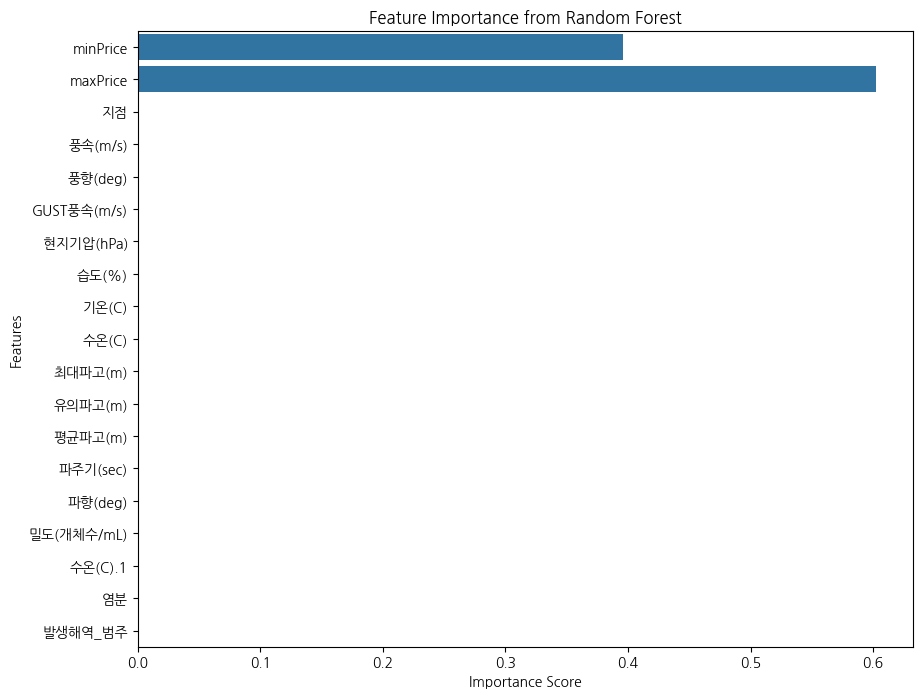

In [31]:
# 파일 불러오기
main_Data = '../data/raw/combined_data.csv'
main_df = pd.read_csv(main_Data)

# ✅ 숫자형 데이터만 추출 (문자열 및 날짜 열 제거)
numeric_df = main_df.select_dtypes(include=['float64', 'int64'])

# ✅ 상관관계 히트맵 생성
plt.figure(figsize=(12, 10))
corr = numeric_df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap with avgPrice")
plt.show()

# ✅ 랜덤 포레스트 모델을 사용해 중요 변수 찾기
# X: avgPrice를 제외한 숫자형 열, y: avgPrice
X = numeric_df.drop(columns=['avgPrice'])
y = main_df['avgPrice']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 학습
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# 예측 및 평가
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

# ✅ 변수 중요도 시각화
importance = rf.feature_importances_
features = X.columns

plt.figure(figsize=(10, 8))
sns.barplot(x=importance, y=features)
plt.title("Feature Importance from Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()


In [ ]:


# 데이터 경로 설정
forecast_file_path = "../data/processed/forecast_merged2.csv"
price_file_path = "../data/raw/ikh_item_price_2025-01-15.csv"

# 데이터 불러오기
forecast_df = pd.read_csv(forecast_file_path)
price_df = pd.read_csv(price_file_path)

# 1. 날짜 형식 변환
forecast_df['일시'] = pd.to_datetime(forecast_df['일시'], errors='coerce')
price_df['priceDate'] = pd.to_datetime(price_df['priceDate'], errors='coerce')

# 2. 날짜 기준으로 두 데이터 병합
merged_df = pd.merge(price_df, forecast_df, left_on='priceDate', right_on='일시', how='inner')

# 3. 금어기 데이터 추가 - 가상 금어기 정보
goldfish_season = {
    '농어': ('2022-05-01', '2022-06-30'),
    '광어': ('2022-04-01', '2022-05-31'),
    '대게': ('2022-07-01', '2022-08-31'),
    '연어': ('2022-09-01', '2022-10-31'),
    '우럭': ('2022-06-01', '2022-07-31'),
    '참돔': ('2022-03-01', '2022-04-30'),
    '방어': ('2022-11-01', '2022-12-31')
}

# 금어기 컬럼 추가
for item, (start, end) in goldfish_season.items():
    merged_df.loc[(merged_df['item'] == item) & (merged_df['priceDate'] >= pd.to_datetime(start)) &
                  (merged_df['priceDate'] <= pd.to_datetime(end)), '금어기'] = True
merged_df['금어기'].fillna(False, inplace=True)

# 4. 결측치 처리
numeric_columns = merged_df.select_dtypes(include=['float64', 'int64']).columns
merged_df[numeric_columns] = merged_df[numeric_columns].apply(pd.to_numeric, errors='coerce')
merged_df.fillna(0, inplace=True)

# ✅ 데이터프레임 출력 함수 (로컬 환경용)
def display_dataframe_to_user(name, dataframe):
    print(f"📊 {name}")
    display(dataframe)

# 데이터프레임 확인
display_dataframe_to_user(name="Merged Fish Price and Weather Data", dataframe=merged_df)

C:\Users\user\AppData\Local\Temp\ipykernel_114492\2053734358.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['금어기'].fillna(False, inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_114492\2053734358.py:34: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df['금어기'].fillna(False, inplace=

📊 Merged Fish Price and Weather Data


,priceDate,minPrice,avgPrice,maxPrice,item,market,지점,일시,풍속(m/s),풍향(deg),...,현지기압(hPa),습도(%),기온(°C),수온(°C),최대파고(m),유의파고(m),평균파고(m),파주기(sec),파향(deg),금어기
0,2020-01-01,25000,28130,30000,농어,노량진 1층,22105,2020-01-01,6.4,284.0,...,1027.5,48.0,3.2,14.8,3.5,2.0,1.4,8.0,41.0,False
1,2020-01-01,25000,28130,30000,농어,노량진 1층,22107,2020-01-01,11.0,354.0,...,1032.2,70.0,5.1,17.6,3.2,2.0,1.4,8.0,357.0,False
2,2020-01-01,25000,28130,30000,농어,노량진 1층,22186,2020-01-01,6.0,326.0,...,1034.2,56.0,1.7,11.1,2.8,1.6,1.2,6.4,333.0,False
3,2020-01-01,25000,28130,30000,농어,노량진 1층,22188,2020-01-01,5.2,348.0,...,1030.7,42.0,2.3,11.6,1.5,0.8,0.6,3.4,298.0,False
4,2020-01-01,25000,28130,30000,농어,노량진 1층,22189,2020-01-01,7.6,317.0,...,0.0,47.0,3.8,17.5,4.4,3.0,2.1,10.7,36.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713206,2020-12-25,30000,30000,30000,방어,부산민락어민활어직판장,22186,2020-12-25,10.7,323.0,...,1024.5,53.0,6.3,11.2,3.0,2.2,1.5,6.4,316.0,False
713207,2020-12-25,30000,30000,30000,방어,부산민락어민활어직판장,22188,2020-12-25,12.1,322.0,...,1018.8,52.0,6.3,13.0,2.1,1.5,1.0,4.6,297.0,False
713208,2020-12-25,30000,30000,30000,방어,부산민락어민활어직판장,22189,2020-12-25,8.9,338.0,...,1017.0,52.0,7.2,17.5,2.2,1.4,1.0,4.3,345.0,False
713209,2020-12-25,30000,30000,30000,방어,부산민락어민활어직판장,22190,2020-12-25,9.2,287.0,...,1016.5,47.0,7.6,14.4,3.3,1.9,1.4,6.4,359.0,False


### 이하 해양환경측정망(용존산소량)

In [7]:
import requests
import xml.etree.ElementTree as ET
import pandas as pd
import sys
import os
current_dir = os.getcwd()
sys.path.append(current_dir)  # 루트 디렉터리 경로 추가  # .py
sys.path.append(os.path.dirname(current_dir))  # 상위 디렉터리 경로 추가  # .ipynb
from configs.API import api_key


In [ ]:
# API 엔드포인트 및 인증키 설정
endpoint = "http://apis.data.go.kr/B553931/service/OceansNemoService2"

# 요청 파라미터 설정
params = {
    "serviceKey": api_key,         # 필수: 인증키 (Decoding된 키 사용)
    "numOfRows": 100,              # 선택: 한 페이지에 몇 개의 결과를 받을지 설정
    "pageNo": 1,                   # 선택: 페이지 번호 (기본값은 1)
    "resultType": "xml",           # 선택: 결과 형식 (xml 또는 json 중 선택 가능)
}

response = requests.get(
    url="http://apis.data.go.kr/B553931/service/OceansNemoService2/getOceansNemo2",
    params={
        'ServiceKey': api_key
    }
)

# API 호출
# response = requests.get(endpoint, params=params)

# 응답 확인 및 출력
if response.status_code == 200:
    print("API 호출 성공")
    print(response.text)  # XML 또는 JSON 형태의 결과 출력
else:
    print(f"API 호출 실패. 상태 코드: {response.status_code}")